# Implementación del teorema de Bayes.

> Para el análisis estadístico, usaremos Zeus, que es una implementación de Python del método Ensemble Slice Sampling (ESS) para la inferencia de parámetros bayesianos. La información del código se puede encontrar en el sitio web oficial de [(zeus)](https://zeus-mcmc.readthedocs.io/en/latest/index.html), y los artículos correspondientes son "Ensemble Slice Sampling" y "zeus: Una implementación en Python del Ensemble Slice Sampling para una inferencia eficiente de parámetros bayesianos". El cuaderno orignial en el que se basa en gran parte este cuaderno es de autoría de la doctora Alma Xochitl Gonzales Morales y el doctor Luis Arturo Ureña Lopez.

En primer lugar, importamos los paquetes a utilizar


In [86]:
#!pip install zeus-mcmc

In [87]:
# show plots inline in the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import matplotlib.gridspec as gridspec
import time
import zeus

## Teoría

### Teorema de Bayes.
Sean A y B dos eventos, la probabilidad de la ocurrencia de un evento se escribe como $P(A)$ y la probabilidad de que no ocurra A, es $P(\bar{A})$, tal que
$$ P(A)+P(\bar{A})=1 $$

Definimos la **probabilidad conjunta** de A y B denotados con $P(A,B)$, como la probabilidad de que A y B ocurran juntas.

Por otra parte, definimos como la **probabilidad condicional** de A dado B, como la probabilidad de que suceda A dado que ha sucedido B, y se denota por $P(A|B)$. 

Con lo anterior, podemos escribir la probabilidad conjunta de la siguiente manera.
$$ P(A,B)=P(A|B) P(B) $$
O invirtiendo el orden de A y B, se obtiene:
$$ P(B,A)=P(B|A) P(A) $$
Dado que $P(A,B)=P(B,A)$, entonces obtenemos el **Teorema de Bayes**, escrito de la siguiente manera.
$$P(A|B)=\dfrac{P(B|A) P(A)}{P(B)}$$

### Función likelihood
Planteamos el problema de inferencia preguntándose ¿qué se puede decir de las propiedades de una distribución de probabilidad dadas las muestras $\{\hat{x}_1,\hat{x}_2,...,\hat{x}_n\}$.

Dada una función de distribución de probabilidad $p(X,\theta)$, donde $X$ representa una variable aleatoria y $\theta$ una colección de parámetros que describen la forma de la función de distribución de probabilidad. 
Para los datos observados $\hat{x}=\{\hat{x}_1,\hat{x}_2,...,\hat{x}_n\}$, escribimos la **Función likelihood** como
$$\mathscr{L}(\theta)=p(X=\hat{x}|\theta)$$
Entonces la probabilidad (densidad) de observar los datos que se han obtenido $(X = \hat{x})$ se considera en función de los parámetros $\theta$. **Es importante recalcar que el likelihood no es una función de distribución de probabilidad sobre $\theta$.**

Para $A\rightarrow \theta$ (parametros) y $B\rightarrow d$ (los datos observados o muestras), escribimos el teorema de Bayes como
$$P(\theta|d)=\dfrac{P(d|\theta) P(\theta)}{P(d)}$$
Definimos la probabilidad **posterior** de $\theta$ como $P(\theta|d)$. Notemos que el likelihood se escribe como P(d|\theta).
También definimos la distribución de probabilidad previa (**prior**) como $p(\theta)$. Representa la probabilidad de obtener el valor de $\theta$ antes de ver los datos (de ahí el nombre). Este es un ingrediente esencial de las estadísticas bayesianas.

El denominador es una constante de normalización, ya que integrando sobre todos los parámetros $\theta$, obtengamos que 
$$\int\dfrac{d\theta P(d|\theta)P(\theta)}{P(d)}=1 \phantom{aaaa}P(d)\int d\theta P(d|\theta)P(\theta)$$

**Es importante que $P(\theta|d)\neq P(d|\theta)$**

### Cadena de Markov Monte Carlo
Para conocer el espacio del posterior de cada parámetro, utilizamos la cadena de Markov Monte Carlo de Zeus. Este método es una simulación para generar muestras de las distribuciones del posterior y estimar cantidades de interés del posterior. Para la simulación del posterior, se generan cierto número de caminadores que muestrean el espacio. Con los datos de la simulación, se obtiene el valor máximo para cada parámetro.

## Ajustar un modelo a un conjunto de datos implementando del teorema de Bayes.

Ya que estamos interesados en ajustar un modelo linear/cuadratico a datos lineales/cuadraticos con cierto error, entonces definimos los modelos.

In [88]:
# Modelo lineal
def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c
# Modelo cuadratico
def quadratic_line(x, d, m, c):
    ''' A quadratic model: y = d*x*x + m*x + c '''
    return  d*x*x+m*x + c

En este caso, se utilizará como modelo real a un modelo cuadrático, para ello, definimos los valores de los coeficientes $d,m,c$ en 
$$f(x)=d x^2+ m x +c$$
Dado que ajustaremos un modelo lineal a uno cuadrático, usaremos un coeficiente d pequeño.

In [89]:
m_true = 3.5 # gradient of the line
c_true = 1.2 # y-intercept of the line
d_true = 0.1 # straight line

Para generar los datos basados en el modelo real, que servirán como muestras, definimos un rango para x y un número de datos, para posteriormete obtener $M$ valores aleatorios de $x$ en este rango $L$

In [90]:
L = 1. #Range of x-data
M = 10 # Number of data points
# x = np.sort(L * np.random.rand(M)) # their x-coordinates

Para una desviación estandar $\sigma$, generamos los datos o muestras que usaremos para un modelo cuadrático. **Estos serán nuestros datos medidos u observados.**

In [91]:
# sigma = 1 # standard deviation of the noise
# data = quadratic_line(x, d_true, m_true, c_true) + sigma * np.random.randn(M)
# primera parte
data = np.array([0,3,6,10,13,16,19,22,26,28])
x = np.array([0,5,10,15,20,25,30,35,40,45])
#zoom de primera parte
data = np.array([19,22,26,28])
x = np.array([30,35,40,45])
# segunda parte
data = np.array([0,9,16,21,31,40,48,59,73,90])
x =    np.array([0,5,10,15,20,25,30,35,40,44])

Graficamos los datos junto con las líneas de los modelos quadrático y lineal con los valores reales de $d,m,c$.

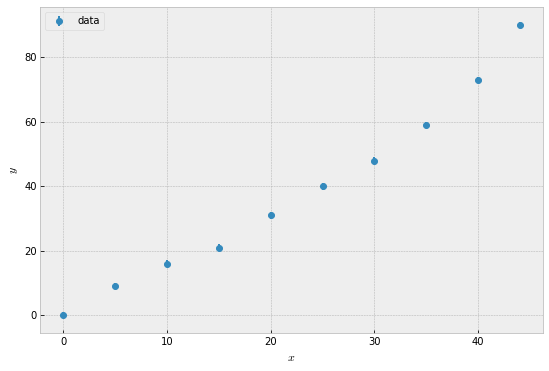

In [92]:
plt.figure(figsize=(9,6))
plt.errorbar(x, data, yerr=sigma, fmt="o", label='data')
# plt.plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='lienal model')
# plt.plot(x, quadratic_line(x, d_true ,m_true, c_true), '-', lw=2, label='quadratic model')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

Escribimos el prior de los parámetros $d,m,c$ como el conjunto $\theta$. Además, el cuaderno está pensado para ajustar un modelo lineal $(p=0)$ o un modelo cuadrático $(p=1)$, es por ello que la función requiere un valor de $p=0,1$. Se define una región en la cual existe el valor real de cada parámetro.

In [93]:
def logprior(theta, p):
    ''' The natural logarithm of the prior probability. '''
    lp = 0.
    # unpack the model parameters from the tuple
    #Agregar parámetro d
    if p == 0:
      m, c = theta
    else: 
      d, m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < c < cmax else -np.inf
    
     # uniform prior on m
    mmin = -15. # lower range of prior
    mmax = 15.  # upper range of prior
    
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp += 0. if mmin < m < mmax else -np.inf
    
    if p == 1:
      # uniform prior on d
      dmin = -5 # lower range of prior
      dmax = 5  # upper range of prior
      # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
      lp += 0. if dmin < d < dmax else -np.inf
    return lp

Definimos el logaritmo del likelihood. Se puede evaluar un modelo cuadrático o un modelo lineal.

In [94]:
def loglike0(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''
    # unpack the model parameters
    m, c = theta
    # evaluate the model
    lin_md = straight_line(x, m, c)
    # return the log likelihood
    return -0.5 * np.sum(((lin_md - data)/sigma)**2)

def loglike1(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''
    # unpack the model parameters
    d, m, c = theta
    # evaluate the model
    quad_md = quadratic_line(x,d,m,c)
    # return the log likelihood
    return -0.5 * np.sum(((quad_md - data)/sigma)**2)
def loglike(theta, data, sigma, x, i):
  if i == 0:
    return loglike0(theta, data, sigma, x)
  else:
    return loglike1(theta, data, sigma, x)

Finalmente, usando el teorema de Bayes, construimos el logaritmo del posterior.

In [95]:
def logpost(theta, data, sigma, x,p):
    '''The natural logarithm of the posterior.'''
    return logprior(theta,p) + loglike(theta, data, sigma, x, p)

### To find the maximum posterior, we will use Zeus.
Para encontrar el máximo del posterior, usamos Zeus. Para ello, necesitamos definir el número de parámetros y si queremos ajustar un modelo lineal $i=0$ o un modelo cuadrático $p=1$

In [96]:
#If a linear regression is desired,set p = 0, if not, we will have a quadratic regression with p = 1.
i = 0
ndim = i + 2 # Number of parameters/dimensions (e.g. m and c)

Definimos el número de caminadores que mapearán el espacio de probabilidades y el número de pasos o iteraciones que dará cada caminador.

In [97]:
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 5000 # Number of steps/iterations.

Inicializamos la posición aleatoria de los caminadores.

In [98]:
start = 0.01 * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.
t0 = time.time()

Comenzamos el muestreo usando Zeus con los parámetros establecidos para ajustar un **modelo lineal** a los datos observados.

In [99]:
sampler0 = zeus.EnsembleSampler(nwalkers, ndim, logpost, args=[data, sigma, x,i]) # Initialise the sampler
sampler0.run_mcmc(start, nsteps) # Run sampling 
sampler0.summary # Print summary diagnostics
print("Multiprocessing took {0:.1f} seconds".format(time.time()-t0))

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:14<00:00, 349.34it/s]
Summary
-------
Number of Generations: 5000
Number of Parameters: 2
Number of Walkers: 10
Number of Tuning Generations: 28
Scale Factor: 0.726763
Mean Integrated Autocorrelation Time: 2.93
Effective Sample Size: 17081.03
Number of Log Probability Evaluations: 284835
Effective Samples per Log Probability Evaluation: 0.059968


Multiprocessing took 14.4 seconds


### We can plot the chains

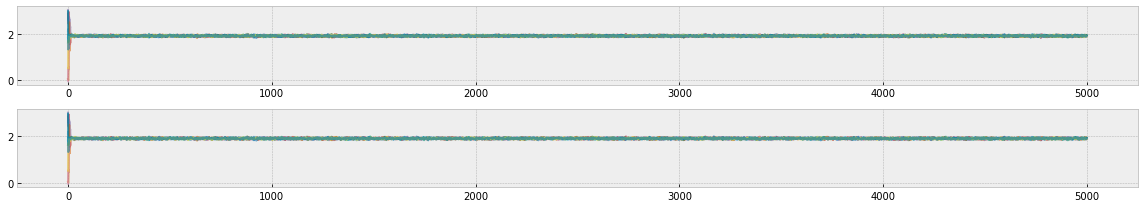

In [100]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler0.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()

Repetimos el proceso de muestreo de Zeus pero para ajustar un **modelo cuadrático** a los datos.

In [101]:
#If a linear regression is desired,set p = 0, if not, we will have a 
#quadratic regression with p = 1.
i = 1
ndim = i + 2 # Number of parameters/dimensions (e.g. m and c)
start = 0.01 * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.
t0 = time.time()
sampler1 = zeus.EnsembleSampler(nwalkers, ndim, logpost, args=[data, sigma, x,i]) # Initialise the sampler
sampler1.run_mcmc(start, nsteps) # Run sampling
    
sampler1.summary # Print summary diagnostics
print("Multiprocessing took {0:.1f} seconds".format(time.time()-t0))

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:13<00:00, 363.64it/s]
Summary
-------
Number of Generations: 5000
Number of Parameters: 3
Number of Walkers: 10
Number of Tuning Generations: 31
Scale Factor: 0.659492
Mean Integrated Autocorrelation Time: 5.8
Effective Sample Size: 8624.72
Number of Log Probability Evaluations: 258521
Effective Samples per Log Probability Evaluation: 0.033362


Multiprocessing took 13.8 seconds


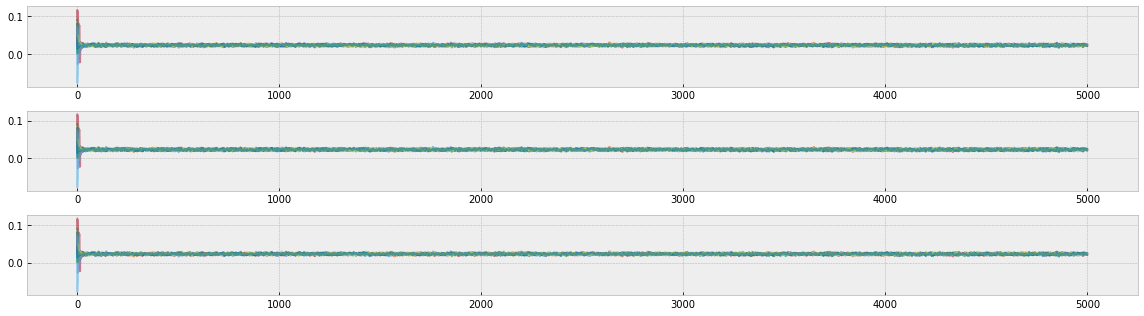

In [102]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler1.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()


Graficamos los posteriors para cada parámetro, junto con una linea que marca el valor real y por encima de la gráfica, el valor máximo obtenido del posterior.
Obtenemos las cadenas chain0 (ajuste de modelo lineal) y chain1 (ajuste de modelo cuadrático).
Se puede elegir ver los priors del ajuste lineal descomentando la penúltima linea del código y comentando la última.

c:\Users\baruc\miniconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
c:\Users\baruc\miniconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
c:\Users\baruc\miniconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
c:\Users\baruc\miniconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
c:\Users\baruc\miniconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
c:\Users\baruc\miniconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  c

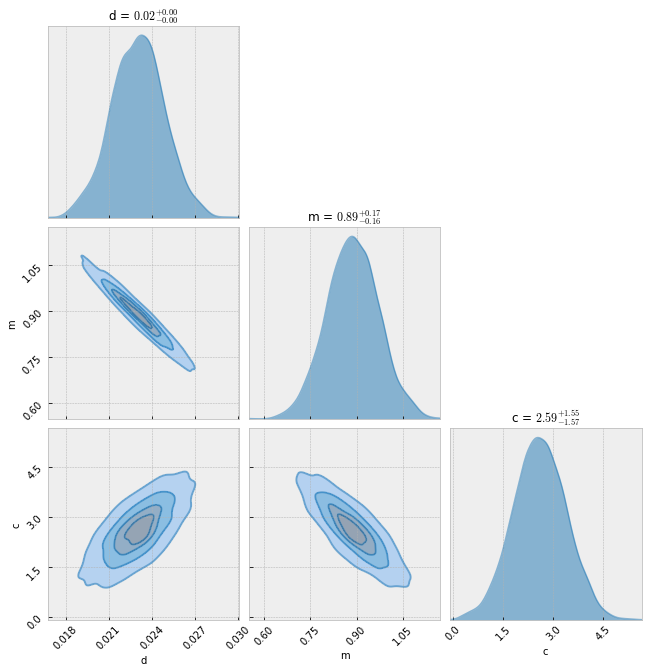

In [103]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain0 = sampler0.get_chain(flat=True, discard=nsteps//3, thin=10)
chain1 = sampler1.get_chain(flat=True, discard=nsteps//3, thin=10)

# plot marginal posterior distributions
# subfig, axes = zeus.cornerplot(chain0, labels=['m', 'c']);
subfig, axes = zeus.cornerplot(chain1, labels=['d','m', 'c']);


Calculamos el valor promedio de cada parámetro y su incertidumbre de 1$\sigma$.



Primero para el ajuste de un modelo lineal sobre los datos.

In [104]:
labels=['m','c']
for p in range(2):
    mcmc = np.percentile(chain0[:, p], [2.5, 50, 97.5])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[p])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Ahora lo calculamos para el ajuste de un modelo cuadrático sobre los datos.

In [105]:
labels=['d','m','c']
for p in range(3):
    mcmc = np.percentile(chain1[:, p], [2.5, 50, 97.5])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[p])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Ahora grafiquemos la proyección de nuestros resultados en el espacio de los datos observados. La forma más sencilla de hacer esto es seleccionar al azar 100 muestras de la cadena y trazar los modelos respectivos en la parte superior de los puntos de datos.

In [106]:
m_fit0 = np.percentile(chain0[:, 0], 50)
c_fit0 = np.percentile(chain0[:, 1], 50)
###
d_fit1 = np.percentile(chain1[:, 0], 50)
m_fit1 = np.percentile(chain1[:, 1], 50)
c_fit1 = np.percentile(chain1[:, 2], 50)

Graficamos cada modelo ajustado a los datos y por último, graficamos el error relativo.

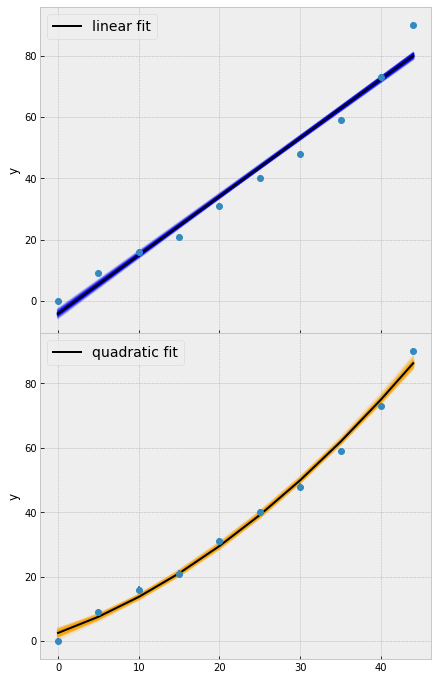

In [107]:
###
plt.style.use('bmh')
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(7,12))
gs=gridspec.GridSpec(2,1, height_ratios=[2,2])
colors=['b','orange']
###
ax1=plt.subplot(gs[0])
inds = np.random.randint(len(chain0[:,1]), size=100)
for ind in inds:
    sample = chain0[ind]
    ax1.plot(x, np.dot(np.vander(x, 2), sample[:2]),colors[0], alpha=0.1)

ax1.errorbar(x, data, yerr=sigma, fmt="o")
# ax1.plot(x, straight_line(x,m_true,c_true), 'k--', label="truth")
ax1.plot(x, straight_line(x,m_fit0,c_fit0), 'k', label="linear fit")

###
inds = np.random.randint(len(chain1), size=100)
ax2=plt.subplot(gs[1])
for ind in inds:
    sample = chain1[ind]
    ax2.plot(x, np.dot(np.vander(x, 3), sample[:3]), colors[1], alpha=0.1)
ax2.errorbar(x, data, yerr=sigma, fmt="o")
# ax2.plot(x, quadratic_line(x,d_true,m_true,c_true), 'k--', label="truth")
ax2.plot(x, quadratic_line(x,d_fit1,m_fit1,c_fit1), 'k', label="quadratic fit")

###

ax1.legend(fontsize=14)
ax2.legend(fontsize=14)
models = ['linear model', 'quadratic model']
ax3.legend(models,loc='best',frameon=False)
ax1.set_ylabel(r'y')
ax3.set_xlabel(r'x')
ax2.set_ylabel(r'y')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

